In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
def extract_masks(model, filters):
    named_mask = {}
    for name, param in model.named_parameters():
        if name in filters:
            continue
        mask = param > 0
        named_mask[name] = mask
    return named_mask

def jaccard_all(masks_a, masks_b):
    # assume masks_a and masks_b contains the same keys and corresponding
    # tensor dimenstion
    union_count = 0
    overlap_count = 0
    for name_param, mask_a in masks_a.items():
        mask_b = masks_b[name_param]
        union = mask_a | mask_b
        union_count += union.sum().item()
        overlap = mask_a & mask_b
        overlap_count += overlap.sum().item()
    return overlap_count/union_count

def extract_num(sample_string):
    numbers = re.findall(r'\d+', sample_string)
    numbers = list(map(int, numbers)) 
    return numbers[0]

def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

def jaccard_layer(masks_a, masks_b):
    # assume masks_a and masks_b contains the same keys and corresponding
    # tensor dimenstion
    layer_overlap = {}
    for name_param, mask_a in masks_a.items():
        if not has_numbers(name_param):
            continue
        l_n = extract_num(name_param)
        mask_b = masks_b[name_param]
        union = mask_a | mask_b
        union_count = union.sum().item()
        overlap = mask_a & mask_b
        overlap_count = overlap.sum().item()
        if l_n in layer_overlap:
            layer_overlap[l_n][0] += overlap_count
            layer_overlap[l_n][1] += union_count
        layer_overlap[l_n] = [overlap_count, union_count]
    return layer_overlap

In [8]:
from utils.constants import *
from prune import build_model_tokenizer

# HIN
# sib_model, _, _ = build_model_tokenizer('/home/raft/atcs-crosslingual-sharing/pruned_models/snip-hin_Deva-41-sib/snip-hin_Deva-41', SIB200)
# wiki_model, _, _ = build_model_tokenizer("/home/raft/atcs-crosslingual-sharing/pruned_models/snip-hi-41-wiki/snip-hi-41", WIKIANN)
# xnli_model, _, _ = build_model_tokenizer("/home/raft/atcs-crosslingual-sharing/pruned_models/snip-hi-41-xnli/snip-hi-41", XNLI)

# CZN
sib_model, _, _ = build_model_tokenizer("/home/raft/atcs-crosslingual-sharing/pruned_models/snip-ces_Latn-41-sib200", SIB200)
wiki_model, _, _ = build_model_tokenizer("/home/raft/atcs-crosslingual-sharing/pruned_models/snip-cs-41-wikiann", WIKIANN)
xnli_model, _, _ = build_model_tokenizer("/home/raft/atcs-crosslingual-sharing/pruned_models/snip-cs-41-xnli", XNLI)

Some weights of XLMRobertaForMultipleChoice were not initialized from the model checkpoint at /home/raft/atcs-crosslingual-sharing/pruned_models/snip-ces_Latn-41-sib200 and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
filters = ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'classifier.weight', 'classifier.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
masks_a = extract_masks(sib_model, filters)
masks_b = extract_masks(wiki_model, filters)
masks_c = extract_masks(xnli_model, filters)
# print(jaccard_all(masks_a, masks_b))

In [10]:
del sib_model, wiki_model, xnli_model

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0.994535519125683, 0.994392523364486, 0.9942748091603053, 0.9981818181818182, 0.9887640449438202, 0.9985569985569985, 0.975, 0.9984639016897081, 1.0, 1.0, 1.0, 1.0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0.994535519125683, 0.9981308411214953, 0.9867172675521821, 0.9872958257713249, 0.9694444444444444, 0.9971139971139971, 0.9271844660194175, 0.9938650306748467, 0.9972144846796658, 0.9946018893387314, 0.9807121661721068, 0.9986910994764397]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[1.0, 0.9962616822429906, 0.9847908745247148, 0.9890909090909091, 0.9692737430167597, 0.9985549132947977, 0.9320388349514563, 0.9923312883435583, 0.9972144846796658, 0.9946018893387314, 0.9807121661721068, 0.9986910994764397]


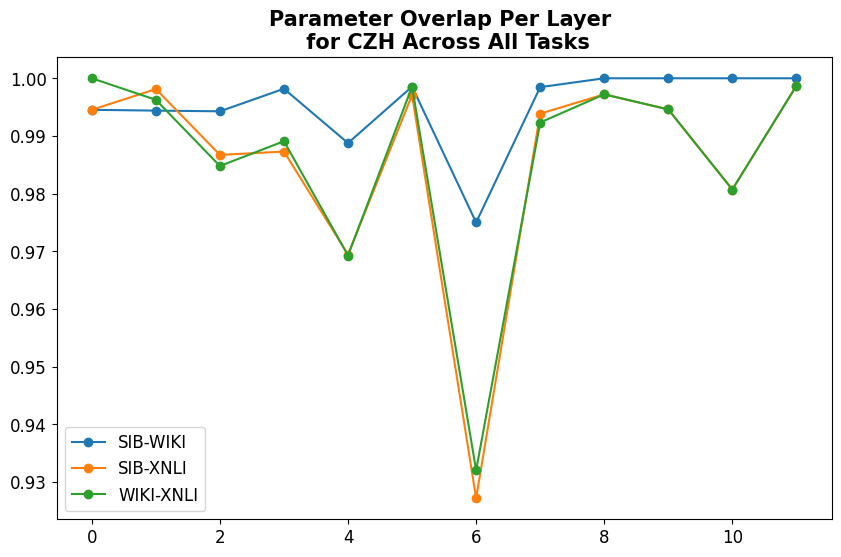

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import re

plt.figure(figsize=(10, 6))

x_labels = ['SIB', 'WIKI', 'XNLI']
y_labels = ['SIB', 'WIKI', 'XNLI']

masks = [masks_a, masks_b, masks_c]
n = len(masks)
mat = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        layers = jaccard_layer(masks[i], masks[j])
        x = []
        y = []
        for l in layers.keys():
            x.append(l)
            y.append(layers[l][0]/layers[l][1])
        print(x)
        print(y)
        plt.plot(x, y, marker='o', label=f'{x_labels[i]}-{y_labels[j]}')

plt.title("Parameter Overlap Per Layer \n for CZH Across All Tasks", fontsize=15, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()


In [6]:
masks = [masks_a, masks_b, masks_c]
n = len(masks)
mat = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        mat[i][j] = jaccard_all(masks[i], masks[j])
print(mat)

[[0.         0.90126154 0.89889815]
 [0.         0.         0.88771291]
 [0.         0.         0.        ]]


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'SIB'), Text(0, 1.5, 'WIKI'), Text(0, 2.5, 'XNLI')])

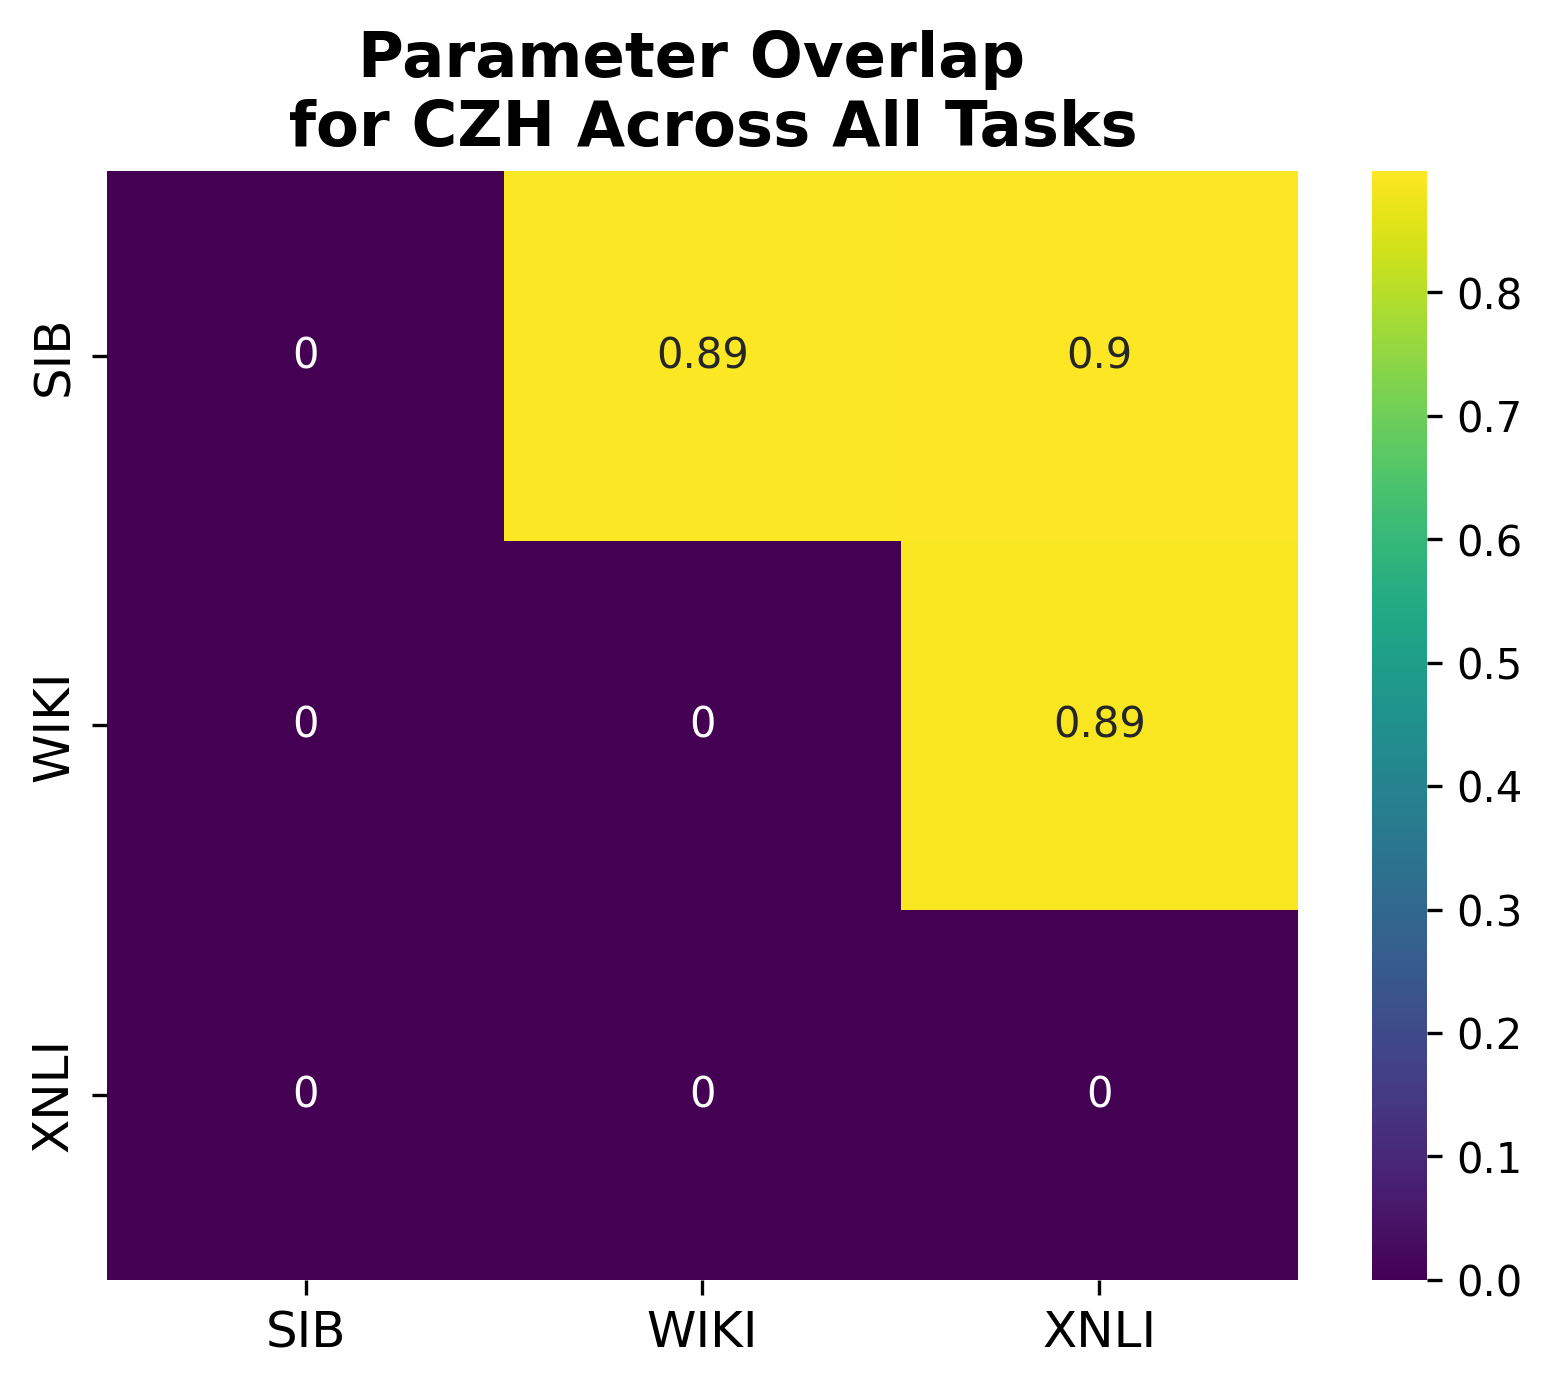

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


# Labels for x and y axes
x_labels = ['SIB', 'WIKI', 'XNLI']
y_labels = ['SIB', 'WIKI', 'XNLI']
# Plotting the heatmap
sns.heatmap(mat, annot=True, cmap='viridis', xticklabels=x_labels, yticklabels=y_labels)

plt.title("Parameter Overlap \n for Hindi Across All Tasks", fontsize=15, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)



(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'SIB'), Text(0, 1.5, 'WIKI'), Text(0, 2.5, 'XNLI')])

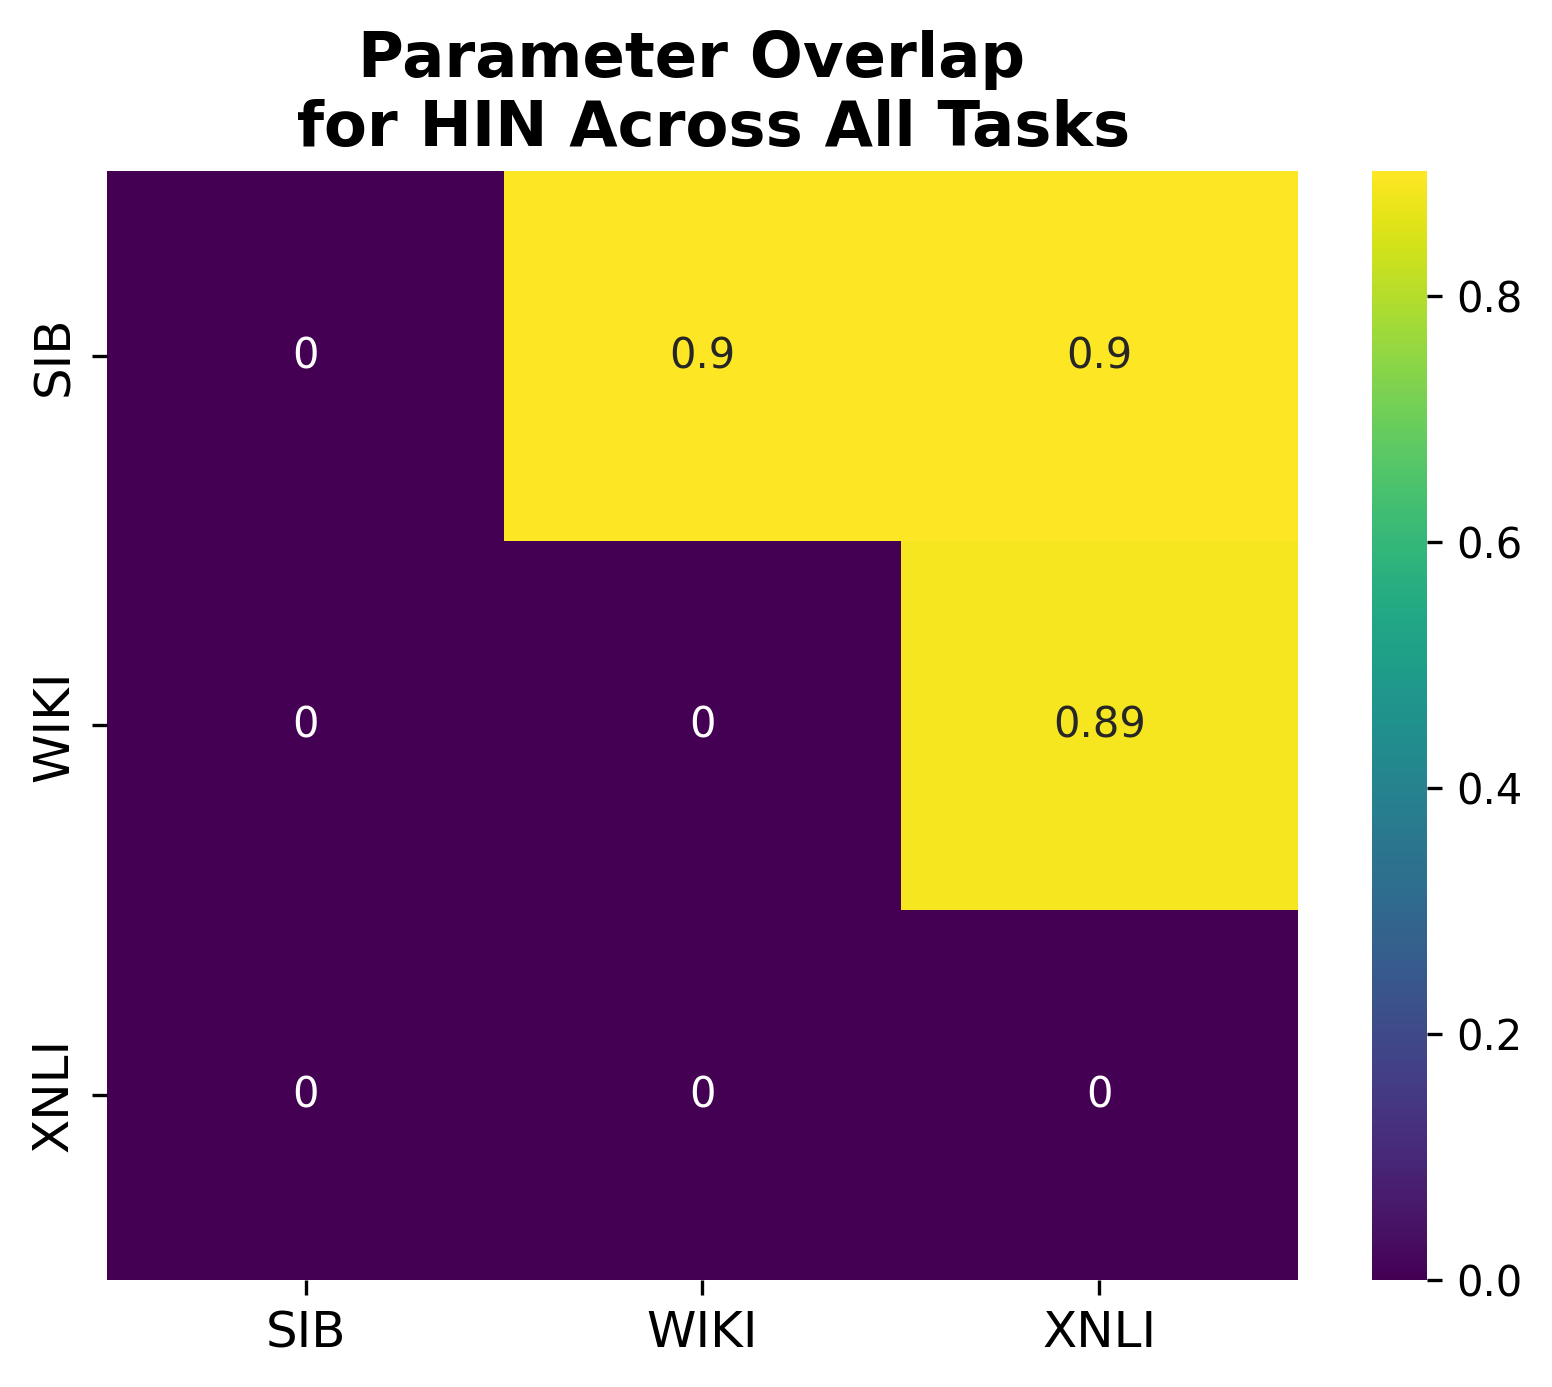

In [10]:
# Plotting the heatmap
sns.heatmap(mat, annot=True, cmap='viridis', xticklabels=x_labels, yticklabels=y_labels)

plt.title("Parameter Overlap \n for HIN Across All Tasks", fontsize=15, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)